### Baseline Models Template for 2016 - 2020 Data (exports)

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA, SparsePCA
from sklearn.covariance import empirical_covariance
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

import seaborn as sns
import joblib
import os
#from adspy_shared_utilities import plot_decision_tree
from datetime import datetime

In [2]:
rng = 42

In [3]:
p = '../data/'
input_name = 'cleaned.csv'

df = pd.read_csv(f'{p}{input_name}')

#### Preprocessing

In [4]:
def df_filtering(df, i_e = 'I', f_cols = []):

    filtered_df = df[df.i_e == i_e]
    filtered_df = filtered_df[f_cols+['act']]
    
    return filtered_df

In [5]:
df.columns

Index(['control_number', 'species_code', 'genus', 'species', 'wildlf_desc',
       'wildlf_cat', 'cartons', 'qty', 'unit', 'value', 'ctry_org', 'ctry_ie',
       'purp', 'src', 'trans_mode', 'act', 'dp_cd', 'disp_date', 'ship_date',
       'i_e', 'pt_cd', 'specific_generic_name', 'disp_date_yyyy',
       'disp_date_mm', 'ship_date_yyyy', 'ship_date_mm', 'disp_ship_date'],
      dtype='object')

In [6]:
non_feature_cols = ['control_number', 'disp_date', 'i_e', 'ship_date', 
                    'cartons', 'qty', 'unit', 'specific_generic_name',
                    'genus', 'species', 'wildlf_cat', 
                    'disp_date_yyyy', 'disp_date_mm', 'disp_ship_date']

target = ['act', 'dp_cd']

feature_cols = ['species_code', 'wildlf_desc', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 
                 'value', 'ship_date_mm']

In [7]:
#import_df = df_filtering(df, i_e = 'I', f_cols = feature_cols)
export_df = df_filtering(df, i_e = 'E', f_cols = feature_cols)
# import: 590505 rows × 11 columns
# export: 299340 rows × 11 columns

In [10]:
# set up folder to save results
os.makedirs('export_run3_TargetEncoding')

In [23]:
prefix = 'export_run3_TargetEncoding/export'

In [12]:
def data_split(df):
    X, y = df.iloc[:,:-1], df.iloc[:,-1:]
    y = np.where(y['act']=='R',1,0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng, stratify=y) 
    
    return X_train, X_test, y_train, y_test
    

In [13]:
X_train, X_test, y_train, y_test = data_split(export_df)

#### column transformer w/ TargetEncoding

In [11]:
from category_encoders.target_encoder import TargetEncoder

In [14]:
categorical_var = ['species_code', 'wildlf_desc', 'ctry_org', 'ctry_ie','purp', 'src', 
                   'trans_mode', 'pt_cd']
numerical_var = ['value']

In [15]:
ct_target = make_column_transformer(
    (StandardScaler(), numerical_var),
    (TargetEncoder(), categorical_var),
    remainder='passthrough')
le = LabelEncoder()

/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [20]:
X_train = ct_target.fit_transform(X_train, y_train)
joblib.dump(X_train, 'X_train_tragetEncoding.joblib')

X_test = ct_target.transform(X_test)
joblib.dump(X_test, 'X_test_tragetEncoding.joblib')
# Found unknown categories 


/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


['X_test_tragetEncoding.joblib']

#### Dummy Classifers

In [21]:
start = datetime.now()
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
end = datetime.now()
print(f'model run time: {end - start}')

# dummy_majority.score(X_test, y_test)
dummy_predicted = dummy_majority.predict(X_test)

model run time: 0:00:00.016193


In [24]:
joblib.dump(dummy_majority, f'{prefix}_dummy_majority_clf.joblib')

['export_run3_TargetEncoding/export_dummy_majority_clf.joblib']

#### Logistic Regression

model run time: 0:00:00.739921
Logistic regression classifier (default settings)
 [[   75   568]
 [   30 74162]]


/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


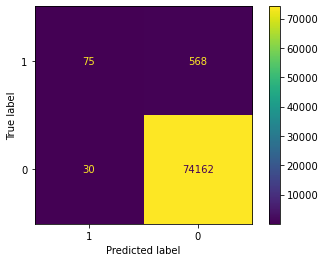

In [56]:
start = datetime.now()
lr = LogisticRegression(random_state=rng).fit(X_train, y_train)
end = datetime.now()
print(f'model run time: {end - start}')

lr_predicted = lr.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted, labels = [1,0])
print('Logistic regression classifier (default settings)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
cm_display.plot()

In [26]:
start = datetime.now()
lr_balanced = LogisticRegression(random_state=rng, class_weight='balanced').fit(X_train, y_train)
end = datetime.now()
print(f'model run time: {end - start}')

lr_balanced_predicted = lr_balanced.predict(X_test)
confusion = confusion_matrix(y_test, lr_balanced_predicted)
print('Logistic regression classifier (balanced)\n', confusion)

model run time: 0:00:01.010160
Logistic regression classifier (balanced)
 [[67745  6447]
 [  295   348]]


/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
joblib.dump(lr, f'{prefix}_lr_clf.joblib')
joblib.dump(lr_balanced, f'{prefix}_lr_balanced_clf.joblib')

['export_run3_TargetEncoding/export_lr_balanced_clf.joblib']

#### Decision Tree

In [28]:
start = datetime.now()
decision_tree_clf = DecisionTreeClassifier(random_state=rng).fit(X_train, y_train)
end = datetime.now()
print(f'model run time: {end - start}')

model run time: 0:00:00.786365


In [29]:
tree_predicted = decision_tree_clf.predict(X_test)
confusion = confusion_matrix(y_test, tree_predicted)
print('Logistic regression classifier (balanced)\n', confusion)

Logistic regression classifier (balanced)
 [[73846   346]
 [  353   290]]


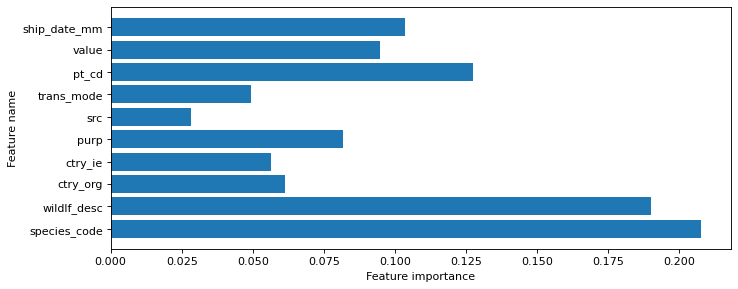

Feature importances: [0.1034151  0.09471394 0.12736673 0.04938061 0.02818066 0.081759
 0.05633878 0.06116747 0.18996441 0.20771333]


In [48]:
from adspy_shared_utilities import plot_feature_importances

plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(decision_tree_clf, feature_cols)
plt.show()

print('Feature importances: {}'.format(decision_tree_clf.feature_importances_[::-1]))

In [30]:
joblib.dump(decision_tree_clf, f'{prefix}_decision_tree_clf.joblib')

['export_run3_TargetEncoding/export_decision_tree_clf.joblib']

#### Random Forest

In [31]:
start = datetime.now()
rf_clf = RandomForestClassifier(random_state=rng).fit(X_train, y_train)
end = datetime.now()
print(f'model run time: {end - start}')

model run time: 0:00:18.235343


In [32]:
rf_predicted = rf_clf.predict(X_test)
confusion = confusion_matrix(y_test, rf_predicted)
print('Logistic regression classifier (balanced)\n', confusion)

Logistic regression classifier (balanced)
 [[74105    87]
 [  376   267]]


In [33]:
joblib.dump(rf_clf, f'{prefix}_rf_clf.joblib')

['export_run3_TargetEncoding/export_rf_clf.joblib']

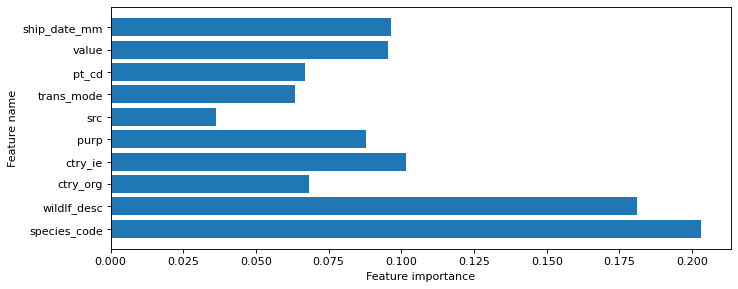

Feature importances: [0.09635666 0.09526445 0.06666391 0.06341149 0.03632125 0.08788921
 0.10143157 0.06837879 0.18115329 0.20312939]


In [47]:
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(rf_clf, feature_cols)
plt.show()

print('Feature importances: {}'.format(rf_clf.feature_importances_[::-1]))

#### Model Evaluation

In [38]:
print('Most frequent class (dummy classifier) \n', 
      classification_report(y_test, dummy_predicted, target_names=['clear', 'seized']))
print('Logistic Regression \n', 
      classification_report(y_test, lr_predicted, target_names=['clear', 'seized']))
print('Logistic Regression (balanced) \n', 
      classification_report(y_test, lr_balanced_predicted, target_names=['clear', 'seized']))
print('Decision Tree \n', 
      classification_report(y_test, tree_predicted, target_names=['clear', 'seized']))
print('Random Forest \n', 
      classification_report(y_test, rf_predicted, target_names=['clear', 'seized']))

/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Most frequent class (dummy classifier) 
               precision    recall  f1-score   support

       clear       0.99      1.00      1.00     74192
      seized       0.00      0.00      0.00       643

    accuracy                           0.99     74835
   macro avg       0.50      0.50      0.50     74835
weighted avg       0.98      0.99      0.99     74835

Logistic Regression 
               precision    recall  f1-score   support

       clear       0.99      1.00      1.00     74192
      seized       0.71      0.12      0.20       643

    accuracy                           0.99     74835
   macro avg       0.85      0.56      0.60     74835
weighted avg       0.99      0.99      0.99     74835

Logistic Regression (balanced) 
               precision    recall  f1-score   support

       clear       1.00      0.91      0.95     74192
      seized       0.05      0.54      0.09       643

    accuracy                           0.91     74835
   macro avg       0.52      0.7

In [35]:
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 

#### PCA

In [ ]:
def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()
    
def plot_pca(pca, f_names, top_k = 10):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(pca.components_[0:top_k], interpolation = 'none', cmap = 'plasma')
    feature_names=f_names
    plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
    plt.yticks(np.arange(0., 2, 1), ['First PC', 'Second PC'], fontsize = 16)
    plt.colorbar()

In [ ]:
ct.named_transformers_
transformed_features = ct.named_transformers_['onehotencoder'].get_feature_names_out()

In [ ]:
pca = PCA(n_components=2, random_state=rng)
X_train_pca = pca.fit_transform(X_train_t.toarray())
print(X_train_t.shape, X_train_pca.shape)

In [ ]:
joblib.dump(X_train_pca, f'{prefix}_X_train_pca.joblib')

In [ ]:
sns.heatmap(empirical_covariance(X_train_pca))

In [ ]:
plot_labelled_scatter(X_train_pca, y_train_t, ['clear', 'seized'])

In [ ]:
plot_pca(pca, transformed_features)

In [ ]:
pca_sparse = SparsePCA(n_components=2, random_state=rng)
X_train_pca_sparse = pca_sparse.fit_transform(X_train_t.toarray())

In [ ]:
joblib.dump(X_train_pca_sparse, f'{prefix}_X_train_pca_sparse.joblib')

In [ ]:
sns.heatmap(empirical_covariance(X_train_pca_sparse))

In [ ]:
plot_pca(pca_sparse, transformed_features)